Google cloud storage has much more capacity then a local "persistent" disk attached to a google cloud instance. Data stored in GCS is also permanent and can be accessed from any computer. If performing reductions of a very large dataset, it would be better to access the data directly from the cloud. Xarray provides tools for this.

This notebook demonstrates how to read a zarr file stored in the google cloud bucket.

In [1]:
%cd /home/noahb/fv3net

/home/noahb/fv3net


In [2]:
import xarray as xr
from src.data.advect import *


def replace_esmf_coords(ds):
    return ds.assign_coords(x=ds.lon.isel(y=0), y=ds.lat.isel(x=0))\
      .drop(['lat', 'lon'])\
      .rename({'x': 'lon', 'y': 'lat'})


In [3]:
ds = xr.open_zarr("data/interim/2019-07-17-FV3_DYAMOND_0.25deg_15minute_regrid_1degree.zarr/")
ds = ds.pipe(replace_esmf_coords)

In [4]:
z_c = height_centered(ds.dz, ds.zs)
qv_t = storage_fixed_height(ds.qv, z_c, ds.dz)
qv_adv = advection_fixed_height(ds, 'qv')
apparent_source = qv_t - qv_adv
net_precitation = (-(apparent_source * ds.dp/9.81).sum('pfull')*86400).persist()

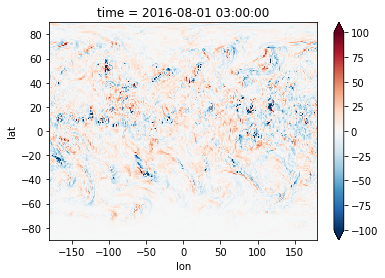

In [5]:
net_precitation[0].plot(vmax=100)